Load the dataset

In [1]:
from pandas import read_csv
# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
dataset = read_csv(url, names=names)

In [3]:
dataset.describe()

,sepal-length,sepal-width,petal-length,petal-width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Class Distribution

In [4]:
print(dataset.groupby('class').size())

class
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
dtype: int64


Create a validation dataset

In [5]:
from sklearn.model_selection import train_test_split
array = dataset.values
X = array[:,0:4]
y = array[:,4]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

Building various Models

- Logistic Regression (LR)
- Linear Discriminant Analysis (LDA)
- K-Nearest Neighbors (KNN).
- Classification and Regression Trees (CART).
- Gaussian Naive Bayes (NB).
- Support Vector Machines (SVM).



In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.941667 (0.065085)
LDA: 0.975000 (0.038188)
KNN: 0.958333 (0.041667)
CART: 0.941667 (0.038188)
NB: 0.950000 (0.055277)
SVM: 0.983333 (0.033333)


Comparing models

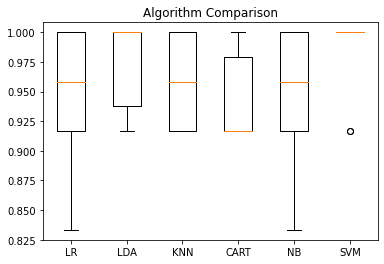

In [7]:
from matplotlib import pyplot
%matplotlib inline
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

Making Predictions

In [8]:
model = SVC(gamma='auto')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

Evaluating Predictions

In [9]:
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9666666666666667
[[11  0  0]
 [ 0 12  1]
 [ 0  0  6]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        11
Iris-versicolor       1.00      0.92      0.96        13
 Iris-virginica       0.86      1.00      0.92         6

       accuracy                           0.97        30
      macro avg       0.95      0.97      0.96        30
   weighted avg       0.97      0.97      0.97        30



**Voting Ensemble for Classification**

knn1 0.873 (0.030)
knn3 0.889 (0.038)
knn5 0.895 (0.031)
knn7 0.899 (0.035)
knn9 0.900 (0.033)
voting 0.902 (0.034)


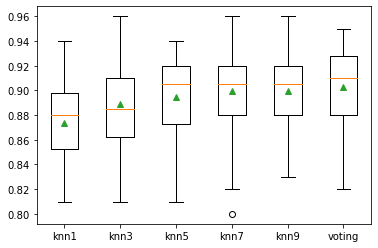

In [10]:
# compare hard voting to standalone classifiers
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from matplotlib import pyplot
%matplotlib inline
# get the dataset
def get_dataset():
    X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=2)
    return X, y

# get a voting ensemble of models
def get_voting():
    # define the base models
    models = list()
    models.append(('knn1', KNeighborsClassifier(n_neighbors=1)))
    models.append(('knn3', KNeighborsClassifier(n_neighbors=3)))
    models.append(('knn5', KNeighborsClassifier(n_neighbors=5)))
    models.append(('knn7', KNeighborsClassifier(n_neighbors=7)))
    models.append(('knn9', KNeighborsClassifier(n_neighbors=9)))
    # define the voting ensemble
    ensemble = VotingClassifier(estimators=models)
    return ensemble

# get a list of models to evaluate
def get_models():
    models = dict()
    models['knn1'] = KNeighborsClassifier(n_neighbors=1)
    models['knn3'] = KNeighborsClassifier(n_neighbors=3)
    models['knn5'] = KNeighborsClassifier(n_neighbors=5)
    models['knn7'] = KNeighborsClassifier(n_neighbors=7)
    models['knn9'] = KNeighborsClassifier(n_neighbors=9)
    models['voting'] = get_voting()
    return models

# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Ensemble for Regression

cart1 -161.519 (11.414)
cart2 -152.596 (11.271)
cart3 -142.378 (10.900)
cart4 -140.086 (12.469)
cart5 -137.641 (12.075)
voting -136.425 (11.199)


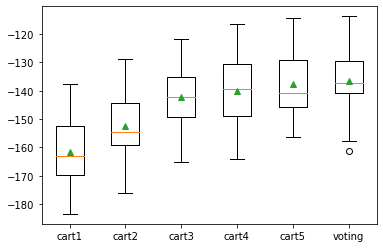

In [11]:
# compare voting ensemble to each standalone models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from matplotlib import pyplot

# get the dataset
def get_dataset():
    X, y = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=1)
    return X, y

# get a voting ensemble of models
def get_voting():
    # define the base models
    models = list()
    models.append(('cart1', DecisionTreeRegressor(max_depth=1)))
    models.append(('cart2', DecisionTreeRegressor(max_depth=2)))
    models.append(('cart3', DecisionTreeRegressor(max_depth=3)))
    models.append(('cart4', DecisionTreeRegressor(max_depth=4)))
    models.append(('cart5', DecisionTreeRegressor(max_depth=5)))
    # define the voting ensemble
    ensemble = VotingRegressor(estimators=models)
    return ensemble

# get a list of models to evaluate
def get_models():
    models = dict()
    models['cart1'] = DecisionTreeRegressor(max_depth=1)
    models['cart2'] = DecisionTreeRegressor(max_depth=2)
    models['cart3'] = DecisionTreeRegressor(max_depth=3)
    models['cart4'] = DecisionTreeRegressor(max_depth=4)
    models['cart5'] = DecisionTreeRegressor(max_depth=5)
    models['voting'] = get_voting()
    return models

# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# Bagging

Bagging performs best with algorithms that have high variance. Random forest is an extension of bagged decision trees.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Importing dataset
df=pd.read_csv('train.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Data Preprocessing

In [14]:
# Data Preprocessing and null values imputation
# Label Encoding
df['Gender']=df['Gender'].map({'Male':1,'Female':0})
df['Married']=df['Married'].map({'Yes':1,'No':0})
df['Education']=df['Education'].map({'Graduate':1,'Not Graduate':0})
df['Dependents'].replace('3+',3,inplace=True)
df['Self_Employed']=df['Self_Employed'].map({'Yes':1,'No':0})
df['Property_Area']=df['Property_Area'].map({'Semiurban':1,'Urban':2,'Rural':3})
df['Loan_Status']=df['Loan_Status'].map({'Y':1,'N':0})

#Null Value Imputation
rev_null=['Gender','Married','Dependents','Self_Employed','Credit_History','LoanAmount','Loan_Amount_Term']
df[rev_null]=df[rev_null].replace({np.nan:df['Gender'].mode(),
                                   np.nan:df['Married'].mode(),
                                   np.nan:df['Dependents'].mode(),
                                   np.nan:df['Self_Employed'].mode(),
                                   np.nan:df['Credit_History'].mode(),
                                   np.nan:df['LoanAmount'].mean(),
np.nan:df['Loan_Amount_Term'].mean()})

Creating Train and Test Sets

In [15]:
X=df.drop(columns=['Loan_ID','Loan_Status']).values
Y=df['Loan_Status'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [16]:
print('Shape of X_train: ',X_train.shape)
print('Shape of X_test : ',X_test.shape)
print('Shape of Y_train: ',Y_train.shape)
print('Shape of Y_test : ',Y_test.shape)

Shape of X_train:  (491, 11)
Shape of X_test :  (123, 11)
Shape of Y_train:  (491,)
Shape of Y_test :  (123,)


Building and Evaluating the Model

In [17]:
# Building Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
dt.fit(X_train, Y_train)
dt_pred_train = dt.predict(X_train)

In [18]:
dt_pred_train = dt.predict(X_train)
print('Training Set Evaluation F1-Score: ',f1_score(Y_train,dt_pred_train))

Training Set Evaluation F1-Score:  1.0


In [19]:
# Evaluating on Test set
dt_pred_test = dt.predict(X_test)
print('Testing Set Evaluation F1-Score: ',np.round(f1_score(Y_test,dt_pred_test),3))

Testing Set Evaluation F1-Score:  0.795


**Building a Random Forest Model**

In [20]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(criterion = 'entropy', random_state = 42)
rfc.fit(X_train, Y_train)

# Evaluating on Training set
rfc_pred_train = rfc.predict(X_train)
print('Training Set Evaluation F1-Score: ',f1_score(Y_train,rfc_pred_train))

Training Set Evaluation F1-Score:  1.0


In [21]:
# Evaluating on Test set
rfc_pred_test = rfc.predict(X_test)
print('Testing Set Evaluation F1-Score: ',np.round(f1_score(Y_test,rfc_pred_test),3))

Testing Set Evaluation F1-Score:  0.846


Why Random Forest Model Outperform than Decision Tree?

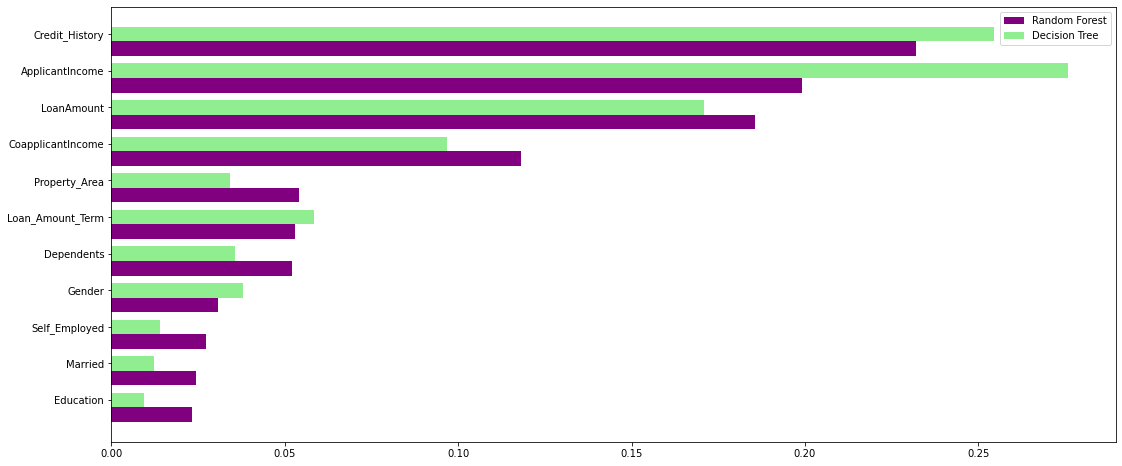

In [22]:
feature_importance=pd.DataFrame({
    'rfc':rfc.feature_importances_,
    'dt':dt.feature_importances_
},index=df.drop(columns=['Loan_ID','Loan_Status']).columns)
feature_importance.sort_values(by='rfc',ascending=True,inplace=True)

index = np.arange(len(feature_importance))
fig, ax = plt.subplots(figsize=(18,8))
rfc_feature=ax.barh(index,feature_importance['rfc'],0.4,color='purple',label='Random Forest')
dt_feature=ax.barh(index+0.4,feature_importance['dt'],0.4,color='lightgreen',label='Decision Tree')
ax.set(yticks=index+0.4,yticklabels=feature_importance.index)

ax.legend()
plt.show()

Boosting

In [25]:
import xgboost as xgb
import warnings
warnings.filterwarnings( "ignore" )
model=xgb.XGBClassifier(learning_rate=0.01,random_state=1)
model.fit(X_train, Y_train)
model.score(X_test,Y_test)

[00:08:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7804878048780488